# Размещение подписей

Выполнил Александр Резанов

<b> Комментарий: <b>
1) Касательно решения - задача сводится к 2-SAT, только мы кодируем бинарно не бокс для вершины, а каждый бокс, каждой вершины. то есть, если у первой вершины 3 возможных положения, а у второй 4, то у нас выходит 7 бинарных величин. Причем из каждого набора (точнее для каждого поинта) истинным может быть только одна переменная

2) Спасибо огромное Игорю Дьяченко за примеры для всех заданий курса

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import networkx as nx
from pysat.solvers import Solver

In [2]:
class Box:
    """
    Класс, в котором хранится каждый бокс. Имеет метод проверки пересечения с границей и с заданным боксом
    """
    def __init__(self, left, bottom, right, top):
        """
        задаем четыре границы и присваиваем глобальный id конкретному боксу
        """
        self.left = left
        self.bottom = bottom
        self.right = right
        self.top = top
        self.width = right - left
        self.height = top - bottom
        global NUMBER
        self._id = NUMBER
        NUMBER += 1 
    
    
    def check_conflict_box(self, another_box=None):
        """
        провереям конфликты, если у нас боксы не пересекаются по y или по x,
        значит не пересекаются вообще, иначе - пересекаются
        """
        if another_box.right < self.left or self.right < another_box.left:
            return False
        if another_box.top < self.bottom or self.top < another_box.bottom:
            return False
        return True
    
    
    def check_border_conflict(self):
        """
        проверяем выход бокса за границы холста
        """
        global MIN_X, MAX_X, MIN_Y, MAX_Y
        return (self.left < MIN_X) or (MAX_X < self.right) or (MAX_Y < self.top) or (self.bottom < MIN_Y)
        
        
    def __str__(self):
        return f"left bottom {(self.left, self.bottom)}, right top {(self.right, self.top)}, id {self._id}"
    
    
    def __repr__(self):
        return str(self)

In [3]:
class Point:
    def __init__(self, point_coord, box_size, possible_box_pos):
        """
        класс для хранения точек, в нем хранится список боксов с их реальным
        положением (при этом в боксы добавляются только боксы, не пересекающие границы холста)
        и их id-шники
        """
        self.coords = point_coord
        self.box_size = box_size
        self.boxes = []
        self.box = None
        self.n = None
        self.boxes_id = []
        for placement in possible_box_pos:
            left = self.coords[0] - placement[0]
            bottom = self.coords[1] - placement[1]
            right = left + self.box_size[0]
            top = bottom + self.box_size[1]
            b = Box(left, bottom, right, top)
            if not b.check_border_conflict():
                self.boxes.append(b)
                self.boxes_id.append(b._id)
    
    
    def find_conflicts_with_other_points(self, other_point):
        """
        ищем какие боксы у этой точки и заданной точки конфликтуют и записываем id конфликтующих боксов
        """
        conflicts = []
        for own_box in self.boxes:
            for other_box in other_point.boxes:
                if own_box.check_conflict_box(other_box):
                    conflicts.append([own_box._id, other_box._id])
        return conflicts
    
    
    def __str__(self):
        return f"coords {self.coords}, box_size {self.box_size}, " + " ".join([f"(box_{i} {str(x)})" for i, x in enumerate(self.boxes)]) + f" MAIN box id {self.box._id if self.box is not None else None}"
      
        
    def __repr__(self):
        return str(self)
    
    
    def plot(self, ax, color):
        """
        рисуем point и его нужный бокс 
        """
        self.box = [box for box in self.boxes if box._id == self.n][0]
        box = Rectangle(
            (self.box.left, self.box.bottom),
            self.box.width,
            self.box.height,
            facecolor=color,
            edgecolor=color,
            lw=1,
            alpha=0.4
        )
        ax.add_patch(box)

In [4]:
class Placer:
    def __init__(self, filename):
        """
        собственно сам размещатель
        парсит файл в лист точек, затем делаем специальный словарь, 
        который по id бокса вернет номер поинта, затем размещаем (с помощью готового 2-sat)
        """
        self.example = filename.split("/")[-1].split(".")[0]
        self.points = self.parse_points(filename)
        self.box_id_to_point_dict = self.box_id_to_point()
        self.get_poses()
        self.plot()
    
    
    def box_id_to_point(self):
        """
        возвращает дикт номер (бокса: номер поинта, которому бокс принадлежит)
        """
        res = {}
        for i, point in enumerate(self.points):
            for box_id in point.boxes_id:
                res[box_id] = i
        return res
                
                
    def get_poses(self):
        """
        собственно говоря ищет нужные боксы
        если для какой-то из точек нет хотя бы одного бокса (все боксы выходят за пределы холста) - 
        значит нет решения
        
        Здесь больше комментариев из-за того, что это - суть и сердце всего решения :-)
        """
        if min([len(p.boxes) for p in self.points]) == 0:
            print("There is no solution because of intersections with borders")
        else:
            # тут собственно говоря создаем солвер и в него добавляем выражения
            self.solver = Solver(name="gc3")
                
            # добавляем выражения, связанные с импликацией
            self.make_point_to_point_conflicts_clause()
                
            #добавляем условие на единственность бокса для каждой точки
            for point in self.points:
                self.make_one_point_constrain(point)

            # проверям, есть ли решение и если есть выбираем те боксы, для которых выражение истинно и для каждого поинта говорим, какой бокс рисовать для него
            self.solved = self.solver.solve()
            if self.solved:
                ids = self.solver.get_model()
                for _id in ids: #берем только боксы с значением переменной равной True
                    if _id >0:
                        self.points[self.box_id_to_point_dict[_id]].n = _id
            else:
                print("There is no solution")
               
            
    def make_one_point_constrain(self, point):
        """ 
        здесь добавлем ограничение на то, что лишь один из боксов для каждой точки может быть выбран - 
        условие на максимум одну истинную переменную (atmost), а чтобы не выбрать все нули - добавляем выражение что дизъюнкция
        для всех боксов одного поинта - равна 1
        в случае трех переменных atmost это (!x1 or !x2) and (!x1 or !x3) and (!x2 or !x3)
        доп условие: x1 or x2 or x3 (чтобы для точки был хоть один бокс)
        """
        point_boxs_ids = point.boxes_id
        self.solver.add_atmost(point_boxs_ids, 1)
        self.solver.add_clause(point_boxs_ids)
        
    
    
    def make_point_to_point_conflicts_clause(self):
        """
        итерируемся по точкам, перебирая все возможные пары, ищем конфликты добавляем импликации в форме дизъюнкций для всех конфликтов между боксами разных точек (x1 -> !x2) <-> (!x1 or !x2)
        """
        for i in range(len(self.points)-1):
            for j in range(i+1, len(self.points)):
                c = self.points[i].find_conflicts_with_other_points(self.points[j])
                for conflict in c:
                    self.solver.add_clause([-conflict[0], -conflict[1]])
    
    
    def parse_points(self, path):
        """
        парсим поинты
        """
        points = []
        with open(path, "r") as f:
            for line in f.readlines():
                d = {}
                coords, size, placement_options= line.split("\t")
                coords = [int(x) for x in coords.split(",")]
                size = [int(x) for x in size.split(",")]
                d["coords"] = coords
                d["size"] = size
                d["placement"] = []
                for placement in placement_options.split(" "):
                    placement = placement.split(",")
                    d["placement"].append([int(placement[0]), int(placement[1])])
                points.append(Point(d["coords"], d["size"], d["placement"]))
        return points
    
    
    def get_colors(self, n, name='hsv'):
        """
        Делаем n различных цветов
        """
        return plt.cm.get_cmap(name, n)
        
    
    def plot(self):
        """
        если боксы возможно разместить - рисуем их
        """
        if self.solved:
            fig, ax = plt.subplots(figsize=(15, 15))
            ax.set_title(f"Label Placement Example Name: {self.example}")
            self.colors = self.get_colors(len(self.points))
            for i, point in enumerate(self.points):
                point.plot(ax, self.colors(i))
                ax.plot(point.coords[0], point.coords[1], "*k")
                ax.text(point.coords[0]-3, point.coords[1]+2, s=(i+1), fontdict=dict(color='black',size=12))
            plt.show()

In [5]:
MIN_X = 0
MAX_X = 500
MIN_Y = 0
MAX_Y = 500
NUMBER = 1

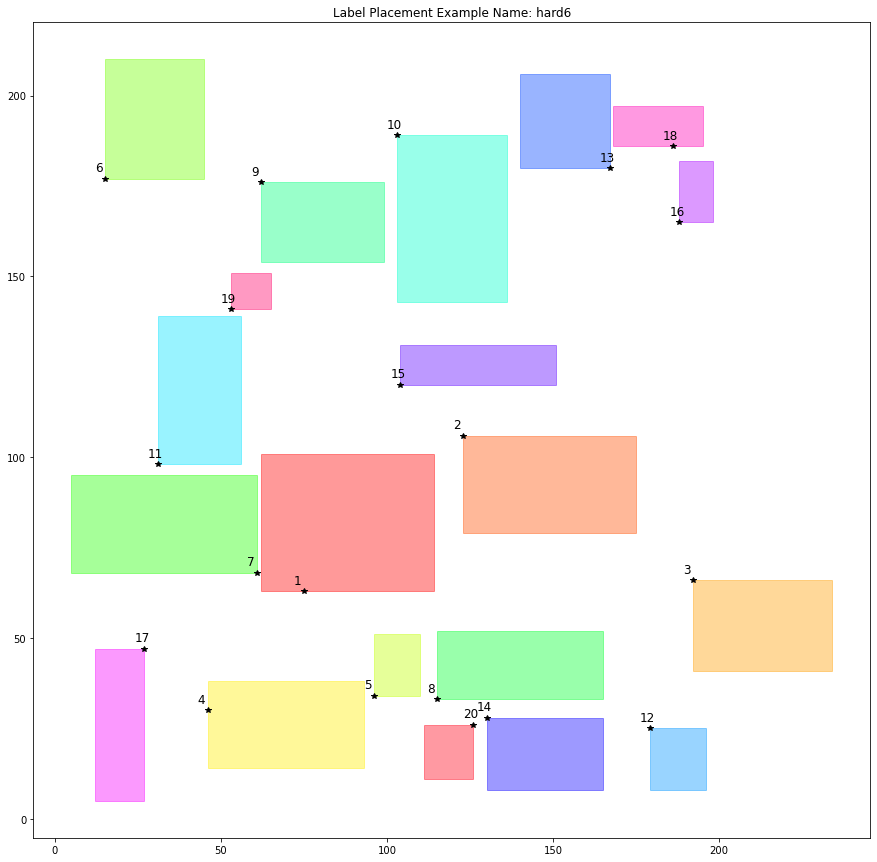

In [6]:
placer = Placer("data/hard6.txt")